In [ ]:
!pip install rasterio

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
!pip install folium

In [ ]:
!pip install earthengine-api --upgrade

In [5]:
import ee
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [6]:
import azureml.core
from azureml.core import Experiment, Workspace, Dataset, Datastore, ScriptRunConfig, Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

import os
import shutil
import glob
from os.path import join
from sys import path

import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import metrics

import numpy as np
import rasterio as rio
import json

# check core SDK version number

print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.18.0


In [6]:
# make sure we have the most current version of github repo
%cd Satellite_ComputerVision
!git pull
%cd ..

/mnt/batch/tasks/shared/LS_root/mounts/clusters/mevans1/code/Users/mevans/Satellite_ComputerVision
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 156 (delta 114), reused 112 (delta 70), pack-reused 0
Receiving objects: 100% (156/156), 39.27 KiB | 59.00 KiB/s, done.
Resolving deltas: 100% (114/114), completed with 5 local objects.
From https://github.com/mjevans26/Satellite_ComputerVision
   013c69c..6c7949d  master     -> origin/master
Updating 013c69c..6c7949d
error: Your local changes to the following files would be overwritten by merge:
	utils/__pycache__/clouds.cpython-36.pyc
Please commit your changes or stash them before you merge.
Aborting
/mnt/batch/tasks/shared/LS_root/mounts/clusters/mevans1/code/Users/mevans


In [7]:
# attach our utilities folder to the path to import modules
path.append('/home/azureuser/cloudfiles/code/Users/mevans/Satellite_ComputerVision/azure')

In [8]:
from utils.model_tools import get_binary_model, make_confusion_matrix, weighted_bce
from utils.processing import get_training_dataset, normalize
from utils.prediction_tools import makePredDataset, make_array_predictions, get_img_bounds
from utils.clouds import basicQA

In [9]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
# get metadata about the workspace
print(ws.name, ws.location, ws.resource_group, sep='\t')
# list the registered datastores
ws.datastores

solar-compviz	eastus2	PLACE


{'autoencoderblob': {
   "name": "autoencoderblob",
   "container_name": "autoencoder",
   "account_name": "changedetectio8527471924",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspaceartifactstore': {
   "name": "workspaceartifactstore",
   "container_name": "azureml",
   "account_name": "solarcompviz6161005396",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'solardatafilestore': {
   "name": "solardatafilestore",
   "container_name": "gee-data",
   "account_name": "solarcompviz6161005396",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspaceblobstore': {
   "name": "workspaceblobstore",
   "container_name": "azureml-blobstore-20200d5f-4836-4a79-bf1c-7bd46e0d0c35",
   "account_name": "solarcompviz6161005396",
   "protocol": "https",
   "endpoint": "core.windows.net"
 },
 'workspacefilestore': {
   "name": "workspacefilestore",
   "container_name": "azureml-filestore-20200d5f-4836-4a79-bf1c-7bd46e0d0c35",
   "account_name": 

In [10]:
# access our registered data share containing image data in this workspace
datastore = Datastore.get(workspace = ws, datastore_name = 'solardatafilestore')

cpk_train_path = (datastore, 'CPK_solar/training/')
cpk_eval_path = (datastore, 'CPK_solar/eval/')

nc_train_path = (datastore, 'NC_solar/training/')
nc_eval_path = (datastore, 'NC_solar/eval/')
test_path = (datastore, 'CPK_solar/predict/testpred6')

train_dataset = Dataset.File.from_files(path = [cpk_train_path, nc_train_path])
eval_dataset = Dataset.File.from_files(path = [cpk_eval_path, nc_eval_path])
test_dataset = Dataset.File.from_files(path = [test_path])


In [11]:
experiment_name = 'solar-nc-cpk'
exp = Experiment(workspace = ws, name = experiment_name)

In [12]:
run_id = 'solar-nc-cpk_1637726302_3d9204e4'

run = ws.get_run(run_id)

run.tags

model_name = 'solar_Nov21'

In [50]:
# if we haven't already registered our model
model = run.register_model(model_name= model_name,
                           tags=run.tags,
                           description = 'UNET model delineating anthropogenic change in pairs of Sentinel-2 imagery',
                           model_path='outputs/',
                           model_framework = 'Tensorflow',
                           model_framework_version= '2.0',
                           datasets = [('training', train_dataset), ('evaluation', eval_dataset), ('testing', test_dataset)])
print(model.name, model.id, model.version, sep='\t')

solar_Nov21	solar_Nov21:1	1


In [13]:
model = Model(ws, model_name)
model_path = model.get_model_path(model_name, _workspace = ws)

In [14]:
model_dir = Model.get_model_path(model_name)
weights_path = glob.glob(os.path.join(model_dir, '*.hdf5'))
model_path = glob.glob(os.path.join(model_dir, '*.h5'))
weights_path
model_path

['azureml-models/solar_Nov21/1/outputs/unet256_24Nov21.h5']

In [15]:
weights_path

['azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_01.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_02.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_03.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_04.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_05.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_08.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_11.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_15.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_16.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_22.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_25.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_33.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_38.hdf5',
 'azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_41.hdf5',
 'azureml-models/sol

In [16]:
# Define some global variabes

BANDS = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
RESPONSE = 'landcover'
FEATURES = BANDS + [RESPONSE]
print(FEATURES)
DEPTH = len(FEATURES)

# Specify the size and shape of patches expected by the model.
KERNEL_SIZE = 256
KERNEL_SHAPE = [KERNEL_SIZE, KERNEL_SIZE]
COLUMNS = [
  tf.io.FixedLenFeature(shape=KERNEL_SHAPE, dtype=tf.float32) for k in FEATURES
]
FEATURES_DICT = dict(zip(FEATURES, COLUMNS))

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

METRICS = {
    'logits':[tf.keras.metrics.MeanSquaredError(name='mse'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
    'classes':[tf.keras.metrics.MeanIoU(num_classes=2, name = 'mean_iou')]
    }

['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'landcover']


In [17]:
def get_weighted_bce(y_true,y_pred):
  return weighted_bce(y_true, y_pred, 1)
# m = models.load_model(f'{model_path[0]}', custom_objects = {'get_weighted_bce': get_weighted_bce})
m = get_binary_model(depth = len(BANDS), optim = OPTIMIZER, loss = get_weighted_bce, mets = METRICS, bias = None)
m.load_weights('azureml-models/solar_Nov21/1/outputs/best_weights_24Nov21_65.hdf5')

WARNING - Output classes missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to classes.


In [18]:
# Create mountcontext and mount the dataset
aoi = 'testpred6'

cpk_test_path = (datastore, f'CPK_solar/predict/{aoi}')

cpk_test_dataset = Dataset.File.from_files(path = [cpk_test_path])

testFiles = []

# open access to the mount point
with cpk_test_dataset.mount() as mount:

    # Get the mount point
    dataset_mount_folder = mount.mount_point
    print(dataset_mount_folder)

    for root, dirs, files in os.walk(dataset_mount_folder):
        for f in files:
            testFiles.append(join(root, f))

    predFiles = [x for x in testFiles if '.gz' in x]
    jsonFiles = [x for x in testFiles if '.json' in x]
    jsonFile = jsonFiles[0]
    predData = makePredDataset(predFiles, BANDS, one_hot = None)
    preds = make_array_predictions(imageDataset = predData, model = m, jsonFile = jsonFile)

/tmp/tmpzfnmz_1e
CRITICAL - MSI: Failed to retrieve a token from 'http://127.0.1.1:46808/MSI/auth/?resource=https://management.core.windows.net/&api-version=2017-09-01' with an error of 'HTTPConnectionPool(host='127.0.1.1', port=46808): Max retries exceeded with url: /MSI/auth/?resource=https://management.core.windows.net/&api-version=2017-09-01 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe88c3809b0>: Failed to establish a new connection: [Errno 111] Connection refused',))'.
CRITICAL - MSI: Failed to retrieve a token from 'http://127.0.1.1:46808/MSI/auth/?resource=https://management.core.windows.net/&api-version=2017-09-01' with an error of 'HTTPConnectionPool(host='127.0.1.1', port=46808): Max retries exceeded with url: /MSI/auth/?resource=https://management.core.windows.net/&api-version=2017-09-01 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fe88f7c6748>: Failed to establish a new connection: [Errno 111] Connection

In [25]:
# predFiles = [x for x in testFiles if '.gz' in x]
# predFiles

['/tmp/tmpcgvo7vsi/raw_unet256_testpred1.tfrecord.gz']

In [26]:
# jsonFiles = [x for x in testFiles if '.json' in x]
# jsonFiles
# jsonFile = jsonFiles[0]

In [ ]:
# predData = makePredDataset(predFiles, BANDS, one_hot = None)
# iterator = iter(predData)
# print(iterator.next())

In [ ]:
# preds = make_array_predictions(imageDataset = predData, model = m, jsonFile = jsonFile)

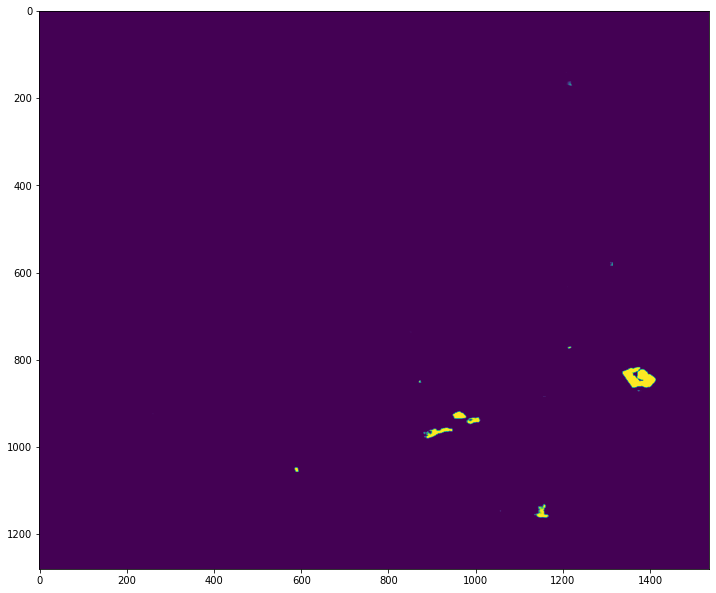

In [19]:
# We can visualize the predictions here in the notebook
from matplotlib import pyplot as plt
from matplotlib import colors

figure = plt.figure(figsize = (12,12))
# cmap = colors.ListedColormap(['#5dc5f1', '#50a886', '#3d6e1d', '#80e144', '#bafb85', '#d4a13e', "#e73522", "#9c9c9c", "#000000", "#706e22", "#e7e64b", "#fefc86", '#ad36ed'])
prob = preds[:, :, 0]
cls = preds[:, :, 1]

plt.imshow(prob)#, norm = colors.BoundaryNorm([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], cmap.N), cmap = cmap)

In [59]:
np.min(prob)

0.8160014748573303

In [20]:
# Folium setup.
import folium
print(folium.__version__)

# Define a method for displaying Earth Engine image tiles to a folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = "Map Data © Google Earth Engine",
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

0.12.1
